Student Name: Divya Acharya

Student ID: 23283742

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code

All the imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models
from torch import sigmoid

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [ ]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

1. **`model.train()`**: Model under training mode

2. **`X, y = X.to(device), y.to(device)`**: The input data and labels are sent to the chosen computing device (CPU or GPU).

3. **`pred = model(X)`**: Producing the model predictions from the input data.

4. **`loss = loss_fn(pred, y)`**: The loss i.e. error is calculated by comparing the model predictions to the actual labels.


5. **`loss.backward()`**: The gradients of the loss with respect to the model parameters are calculated.

6. **`optimizer.step()`**: The weights of the model are updated depending on the calculated gradients.


7. **`optimizer.zero_grad()`**: Clears old gradients to prevent gathering from previous forward and backward passes.



### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
Path = '/content/drive/MyDrive/Divya/'

# Define the transformations
transform = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor(),transforms.Normalize(mean = 0.2859,std = 0.3530)])

# Loading Fashion-MNIST dataset
train_data = datasets.FashionMNIST(root=Path, train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root=Path, train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 117994142.93it/s]


Extracting /content/drive/MyDrive/Divya/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 21783368.39it/s]

Extracting /content/drive/MyDrive/Divya/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 62299566.73it/s]


Extracting /content/drive/MyDrive/Divya/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6807149.11it/s]

Extracting /content/drive/MyDrive/Divya/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST/raw



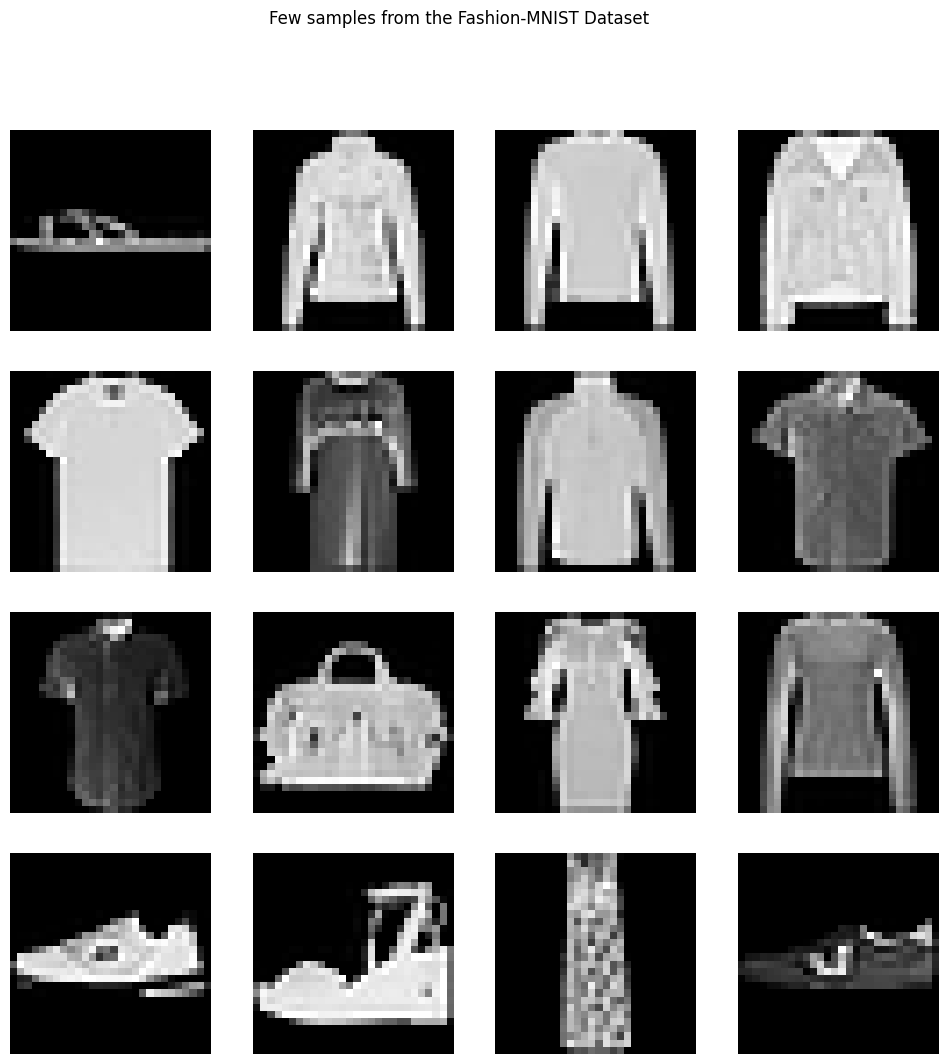

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Few samples from the Fashion-MNIST Dataset")
column, rows = 4, 4
for i in range(1, column * rows + 1):
    index = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[index]
    fig.add_subplot(rows, column, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

#### Using (100,100,50) Network from the last Activity - the best model

In [ ]:
##############################
# Your code below

sequential_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10)  # Output layer with 10 classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sequential_model.to(device)

summary(sequential_model, (1, 28*28)) # Assumes input size is (batch_size, channels, height, width)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                   [-1, 50]           5,050
              ReLU-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.36
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sequential_model.parameters(), lr=1e-3)

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, sequential_model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 0.435670  [   64/60000]
loss: 0.412380  [ 6464/60000]
loss: 0.428621  [12864/60000]
loss: 0.302101  [19264/60000]
loss: 0.424328  [25664/60000]
loss: 0.335193  [32064/60000]
loss: 0.426223  [38464/60000]
loss: 0.409191  [44864/60000]
loss: 0.184295  [51264/60000]
loss: 0.464501  [57664/60000]
Train Error: 
 Accuracy: 86.9%, Avg loss: 0.356227 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.405528 

Epoch 2:

loss: 0.309176  [   64/60000]
loss: 0.426626  [ 6464/60000]
loss: 0.522872  [12864/60000]
loss: 0.308367  [19264/60000]
loss: 0.169359  [25664/60000]
loss: 0.315327  [32064/60000]
loss: 0.309104  [38464/60000]
loss: 0.419078  [44864/60000]
loss: 0.300822  [51264/60000]
loss: 0.440278  [57664/60000]
Train Error: 
 Accuracy: 88.8%, Avg loss: 0.304314 

Test Error: 
 Accuracy: 86.3%, Avg loss: 0.366850 

Epoch 3:

loss: 0.309282  [   64/60000]
loss: 0.186274  [ 6464/60000]
loss: 0.275334  [12864/60000]
loss: 0.359784  [19264/60000]
loss: 0.483440  [25664/60000]
loss: 0.45

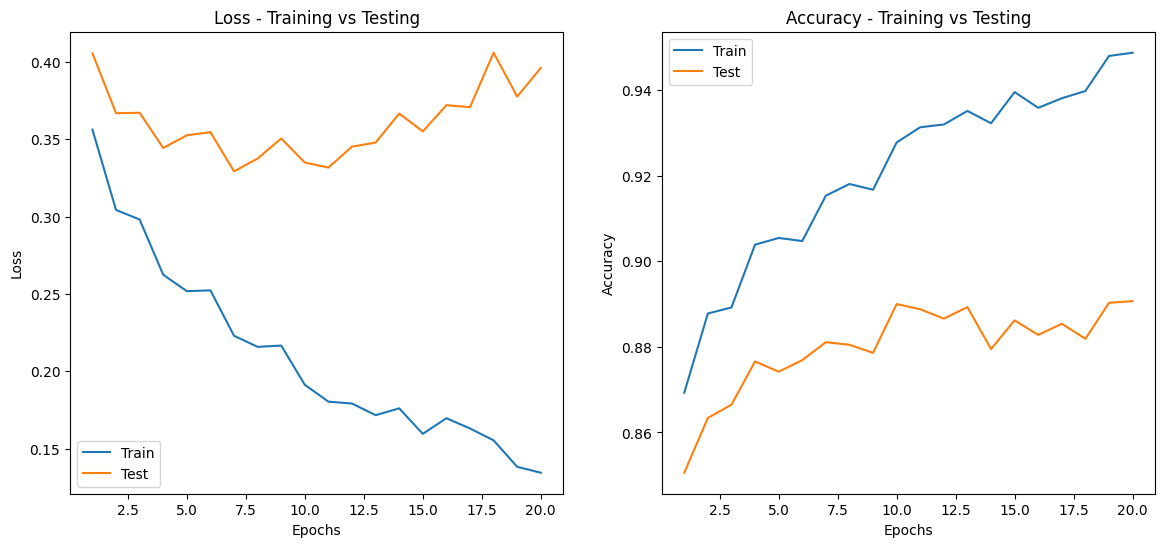

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>


**Train Accuracy** -> 94.9%

**Test Accuracy** -> 89.1%

**Train Loss** -> 0.134472

**Test Loss** -> 0.396119


The model seems to be a bit overfitted since the testing accuracy is less than the training accuracy and the testing loss is more than the training loss.



---

# 2. Replicate LeNet-5 for Fashion-MNIST

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

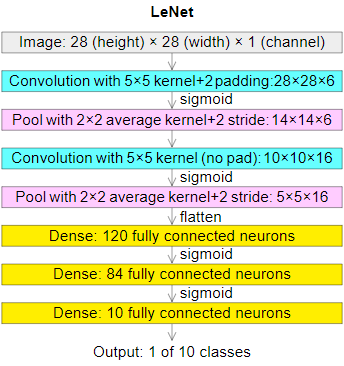

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
lenet_model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet_model.to(device)


summary(lenet_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, lenet_model, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.304441  [   64/60000]
loss: 1.936283  [ 6464/60000]
loss: 1.240980  [12864/60000]
loss: 0.983794  [19264/60000]
loss: 0.961861  [25664/60000]
loss: 0.729196  [32064/60000]
loss: 0.567884  [38464/60000]
loss: 0.739665  [44864/60000]
loss: 0.636547  [51264/60000]
loss: 0.753876  [57664/60000]
Train Error: 
 Accuracy: 74.7%, Avg loss: 0.658761 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.678168 

Epoch 2:

loss: 0.709177  [   64/60000]
loss: 0.527842  [ 6464/60000]
loss: 0.557627  [12864/60000]
loss: 0.471031  [19264/60000]
loss: 0.632102  [25664/60000]
loss: 0.503864  [32064/60000]
loss: 0.672224  [38464/60000]
loss: 0.581592  [44864/60000]
loss: 0.688974  [51264/60000]
loss: 0.588580  [57664/60000]
Train Error: 
 Accuracy: 79.2%, Avg loss: 0.531320 

Test Error: 
 Accuracy: 78.3%, Avg loss: 0.553898 

Epoch 3:

loss: 0.499862  [   64/60000]
loss: 0.543824  [ 6464/60000]
loss: 0.516427  [12864/60000]
loss: 0.410080  [19264/60000]
loss: 0.563494  [25664/60000]
loss: 0.44

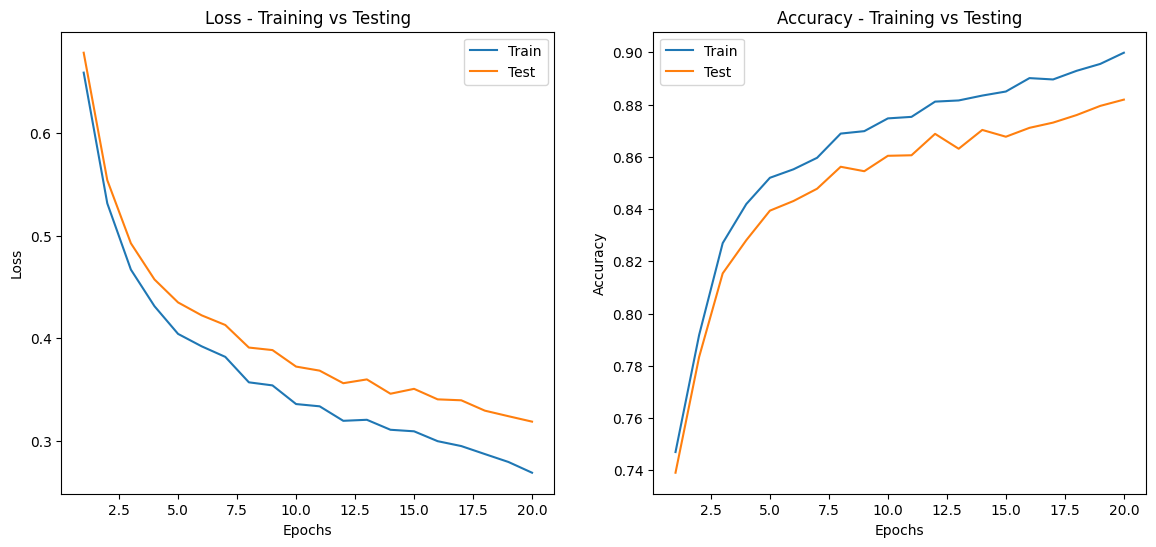

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>


**Train Accuracy** -> 90.0%

**Test Accuracy** -> 88.2%

**Train Loss** -> 0.268767

**Test Loss** -> 0.318566


Fully Connected Model have 94,160 trainable parameters on the other hand LeNet Model has 61,706 trainable parameters.

The Fully Connected model, has a higher parameter count due to its fully connected layers where each neuron is connected to every neuron in the subsequent layer.

The Fully Connected model, tends to overfit, evident from its higher training performance but lower testing performance.


LeNet, has fewer parameters because of its use of shared weights in its convolutional layers, making it generally more efficient and less prone to overfitting than fully connected networks.

LeNet, optimized for image data with fewer parameters, shows a more balanced and effective performance in both training and testing, suggesting better adaptability  and reduced overfitting.

---
# 3. Modernise LeNet
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
update_lenet = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10)
)

# Send the sequential model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_lenet.to(device)

# Display the model summary
summary(update_lenet, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(update_lenet.parameters(), lr=1e-3)

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, update_lenet, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.310751  [   64/60000]
loss: 0.846638  [ 6464/60000]
loss: 0.602046  [12864/60000]
loss: 0.501385  [19264/60000]
loss: 0.541900  [25664/60000]
loss: 0.433991  [32064/60000]
loss: 0.325681  [38464/60000]
loss: 0.590930  [44864/60000]
loss: 0.382972  [51264/60000]
loss: 0.323241  [57664/60000]
Train Error: 
 Accuracy: 86.0%, Avg loss: 0.380304 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.405814 

Epoch 2:

loss: 0.372664  [   64/60000]
loss: 0.230603  [ 6464/60000]
loss: 0.310454  [12864/60000]
loss: 0.234093  [19264/60000]
loss: 0.294120  [25664/60000]
loss: 0.236044  [32064/60000]
loss: 0.335555  [38464/60000]
loss: 0.469623  [44864/60000]
loss: 0.392976  [51264/60000]
loss: 0.475638  [57664/60000]
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.322597 

Test Error: 
 Accuracy: 86.7%, Avg loss: 0.358380 

Epoch 3:

loss: 0.232638  [   64/60000]
loss: 0.406127  [ 6464/60000]
loss: 0.210448  [12864/60000]
loss: 0.389556  [19264/60000]
loss: 0.357363  [25664/60000]
loss: 0.26

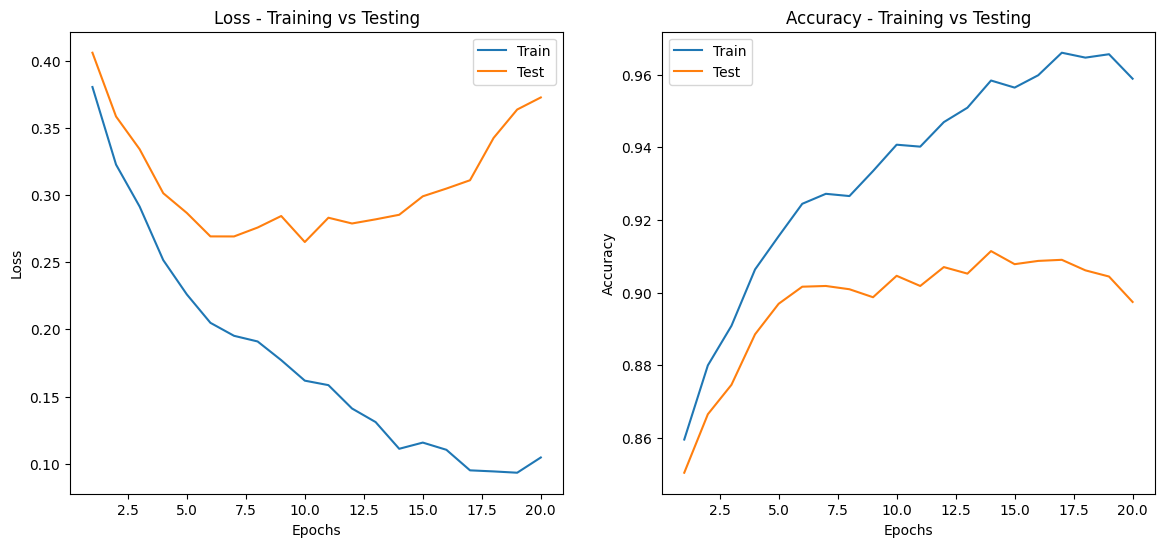

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>


**Train Accuracy** -> 95.9%

**Test Accuracy** -> 89.7%

**Train Loss** -> 0.104711

**Test Loss** -> 0.372539

Train accuracy is good, test accuracy is slightly lower, shows overfitting possibilty.

Pooling Layers: Updated LeNET model use Max Pooling (MaxPool2d) compared to the Average Pooling (AvgPool2d) used in LeNet-5 model. Max pooling is often more successful in extracting dominating features, which leads to better performance in case of Updated LeNeT as compared to LeNet-5 model.

ReLU activation functions are added to Updated LeNet right after each convolutional layer, which will aid the model in learning increasingly complex patterns in the network.


Because of the type of pooling layers and the type of activation functions, the performance have improved. This also shows how making small modification in the Network could impact the adaptability capabilities of a neural network.



---
# 4. Build your own CNN model
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
model_cnn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 10)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn.to(device)

summary(model_cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 512]       1,606,144
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model_cnn, loss_fn, optimizer, epochs)

Epoch 1:

loss: 2.315043  [   64/60000]
loss: 0.353043  [ 6464/60000]
loss: 0.302815  [12864/60000]
loss: 0.365614  [19264/60000]
loss: 0.292289  [25664/60000]
loss: 0.223376  [32064/60000]
loss: 0.334928  [38464/60000]
loss: 0.259665  [44864/60000]
loss: 0.231089  [51264/60000]
loss: 0.265155  [57664/60000]
Train Error: 
 Accuracy: 91.5%, Avg loss: 0.228625 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.278868 

Epoch 2:

loss: 0.220921  [   64/60000]
loss: 0.214705  [ 6464/60000]
loss: 0.329721  [12864/60000]
loss: 0.260918  [19264/60000]
loss: 0.390253  [25664/60000]
loss: 0.408640  [32064/60000]
loss: 0.146109  [38464/60000]
loss: 0.367111  [44864/60000]
loss: 0.155955  [51264/60000]
loss: 0.170910  [57664/60000]
Train Error: 
 Accuracy: 93.1%, Avg loss: 0.184562 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.263745 

Epoch 3:

loss: 0.217852  [   64/60000]
loss: 0.202164  [ 6464/60000]
loss: 0.177290  [12864/60000]
loss: 0.187918  [19264/60000]
loss: 0.231481  [25664/60000]
loss: 0.13

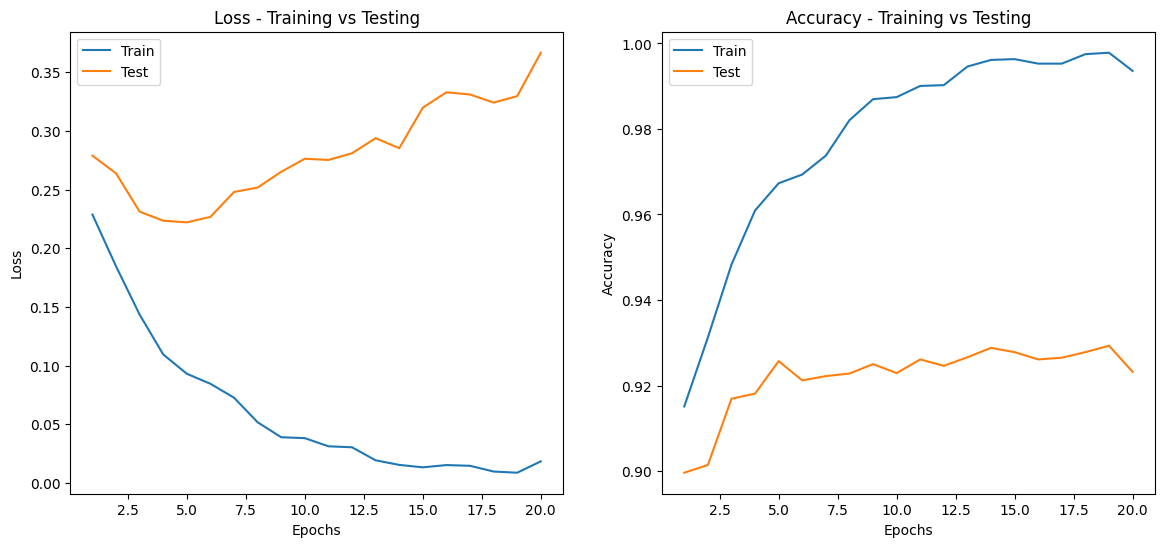

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

**Train Accuracy** -> 99.4%

**Test Accuracy** -> 92.3%

**Train Loss** -> 0.018343

**Test Loss** -> 0.366575

### Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like

Yes, I am able to get till 92.3% accuracy.






### Explain what you did that improved things for the classification and why they improved things.

Batch Normalisation: Adding Batch Normalisation before fully connected layers and after convolutional layers improved training. By normalising the layer outputs, it reduces internal covariance change and improves the performance of the model.

Dropout: Using dropout in the network helps prevent overfitting because of the large number of parameters. During training, the network is compelled to build more reliable and redundant representations by randomly deactivating certain neurons, which improves adaption to incoming input.

Filters and Max Pooling: By combining max pooling with an increased number of filters (32 and 64), the model is better able to learn and the summary high-level features while lowering the probability of overfitting. It also gathers a wider variety of data from the input data, which enhances its ability to to identify a wide range of patterns.

### Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)

There are various advantages to using  3x3 convolutional layers in a CNN as as compared to 5x5 layer. The network's depth is increased by these smaller, stacked layers, which improves its ability to learn complex complex features that are essential for tasks like image recognition. Additionally, this method uses less parameters than a single 5x5 layer, which results in a more compact and less prone to overfitting model. This makes it more parameter-efficient. By introducing additional activation functions and depth, the network can also include more non-linearity. This allows the network to execute sequential non-linear transformations to the input data, which improves its ability to capture complex patterns.


---
# 5. Transfer Learning
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.
Path=PATH = '/content/drive/MyDrive/Divya/FashionMNIST_transfer_learning'
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root=Path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root=PATH,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100%|██████████| 26421880/26421880 [00:00<00:00, 116257480.50it/s]


Extracting /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8577805.06it/s]

Extracting /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 61975861.78it/s]


Extracting /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24398053.10it/s]


Extracting /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Divya/FashionMNIST_transfer_learning/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

## Part A:  From `torchvision.models`, load [`ResNet18`], and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer.

In [ ]:
resnet1 = models.resnet18(weights=None)
resnet1.fc = nn.Linear(resnet1.fc.in_features, 10)

resnet1.to(device)

# Display the model summary
summary(resnet1, (3,28,28)) # Assumes input size is (batch_size, channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet1.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, resnet1, loss_fn, optimizer, epochs)


Epoch 1:

loss: 2.826925  [   64/60000]
loss: 0.529615  [ 6464/60000]
loss: 0.326842  [12864/60000]
loss: 0.507662  [19264/60000]
loss: 0.475492  [25664/60000]
loss: 0.430782  [32064/60000]
loss: 0.335538  [38464/60000]
loss: 0.467058  [44864/60000]
loss: 0.353131  [51264/60000]
loss: 0.344041  [57664/60000]
Train Error: 
 Accuracy: 84.8%, Avg loss: 0.395973 

Test Error: 
 Accuracy: 83.3%, Avg loss: 0.440756 

Epoch 2:

loss: 0.312067  [   64/60000]
loss: 0.329355  [ 6464/60000]
loss: 0.275274  [12864/60000]
loss: 0.299164  [19264/60000]
loss: 0.294845  [25664/60000]
loss: 0.340822  [32064/60000]
loss: 0.241350  [38464/60000]
loss: 0.328064  [44864/60000]
loss: 0.223002  [51264/60000]
loss: 0.303015  [57664/60000]
Train Error: 
 Accuracy: 86.4%, Avg loss: 0.350011 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.395176 

Epoch 3:

loss: 0.257143  [   64/60000]
loss: 0.228240  [ 6464/60000]
loss: 0.221600  [12864/60000]
loss: 0.216594  [19264/60000]
loss: 0.266205  [25664/60000]
loss: 0.32

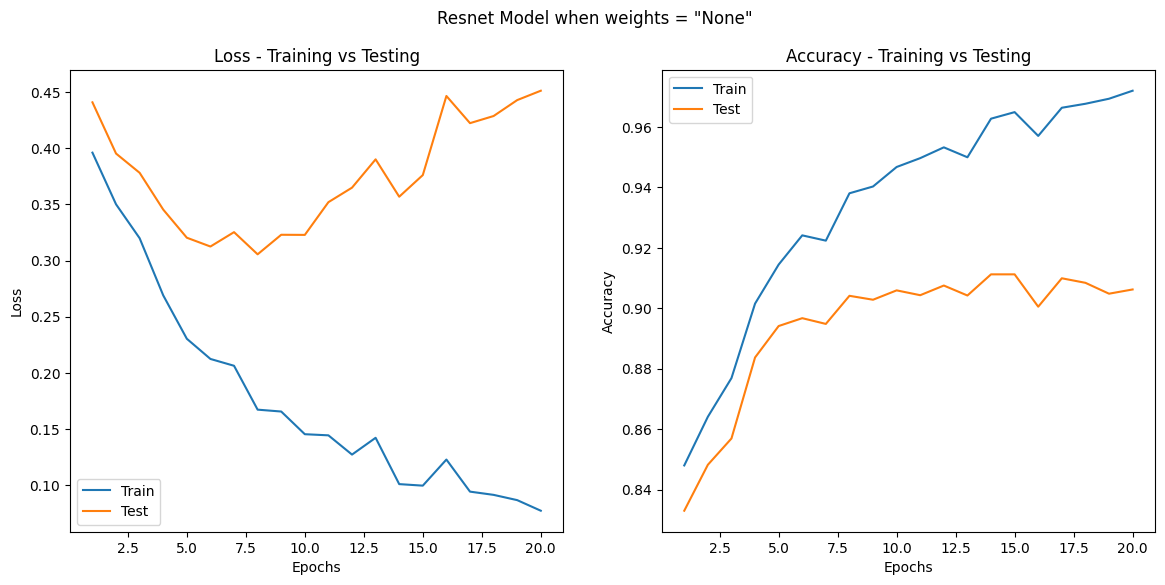

In [ ]:
##############################
# Your code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Resnet Model when weights = "None"',)

ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

## Part B: Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.

In [ ]:
resnet2 = models.resnet18()
resnet2.fc = nn.Linear(resnet2.fc.in_features, 10)

resnet2.to(device)

# Display the model summary
summary(resnet2, (3,28,28)) # Assumes input size is (batch_size, channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet2.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, resnet2, loss_fn, optimizer, epochs)


Epoch 1:

loss: 2.543097  [   64/60000]
loss: 0.557133  [ 6464/60000]
loss: 0.322349  [12864/60000]
loss: 0.441373  [19264/60000]
loss: 0.436020  [25664/60000]
loss: 0.390413  [32064/60000]
loss: 0.296322  [38464/60000]
loss: 0.517350  [44864/60000]
loss: 0.362450  [51264/60000]
loss: 0.348986  [57664/60000]
Train Error: 
 Accuracy: 86.9%, Avg loss: 0.348124 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.393535 

Epoch 2:

loss: 0.322385  [   64/60000]
loss: 0.310286  [ 6464/60000]
loss: 0.228356  [12864/60000]
loss: 0.313682  [19264/60000]
loss: 0.323154  [25664/60000]
loss: 0.395985  [32064/60000]
loss: 0.295313  [38464/60000]
loss: 0.425436  [44864/60000]
loss: 0.247201  [51264/60000]
loss: 0.299273  [57664/60000]
Train Error: 
 Accuracy: 87.2%, Avg loss: 0.332439 

Test Error: 
 Accuracy: 85.7%, Avg loss: 0.381862 

Epoch 3:

loss: 0.267603  [   64/60000]
loss: 0.271346  [ 6464/60000]
loss: 0.203263  [12864/60000]
loss: 0.263480  [19264/60000]
loss: 0.273552  [25664/60000]
loss: 0.36

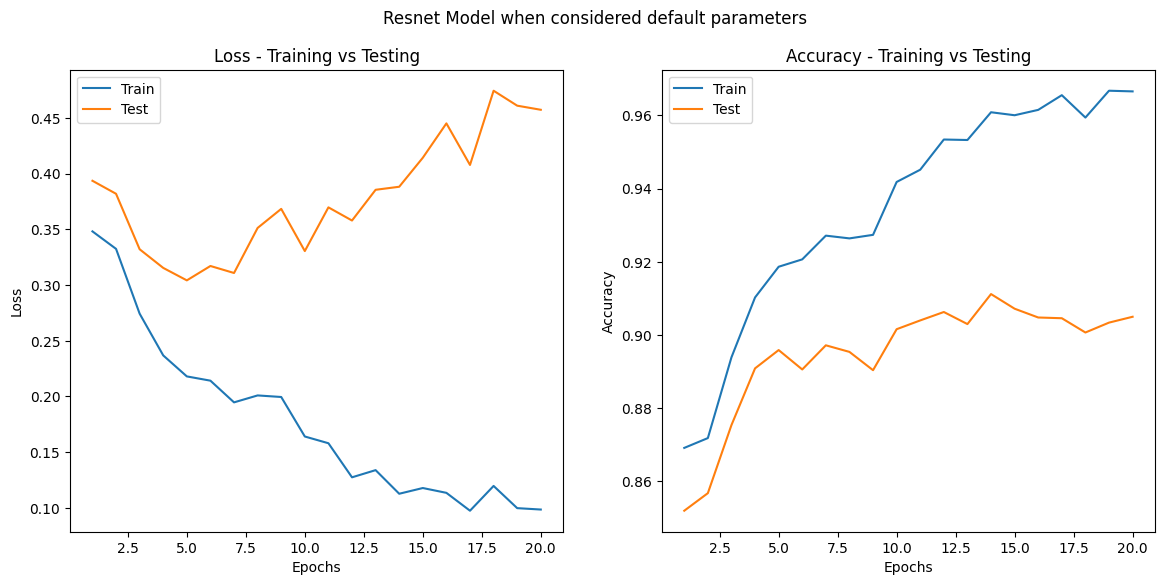

In [ ]:
##############################
# Your code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Resnet Model when considered default parameters',)

ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

## Part C: Freeze all but the last layer of your adapted ResNet model, and retrain.


In [ ]:
resnet3 = models.resnet18()
resnet3.fc = nn.Linear(resnet3.fc.in_features, 10)

for name, param in resnet3.named_parameters():
    print(f"{name}: {param.size()}")

conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
layer1.0.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight: torch.Size([64])
layer1.0.bn1.bias: torch.Size([64])
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight: torch.Size([64])
layer1.0.bn2.bias: torch.Size([64])
layer1.1.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight: torch.Size([64])
layer1.1.bn1.bias: torch.Size([64])
layer1.1.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight: torch.Size([64])
layer1.1.bn2.bias: torch.Size([64])
layer2.0.conv1.weight: torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight: torch.Size([128])
layer2.0.bn1.bias: torch.Size([128])
layer2.0.conv2.weight: torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight: torch.Size([128])
layer2.0.bn2.bias: torch.Size([128])
layer2.0.downsample.0.weight: torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight: torch.Size([128])
layer2.0.downsample.1.bias: torch.Size([128])
l

In [ ]:
# Freeze all layers except the last layer
for name, param in resnet3.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

resnet3.to(device)

# Display the CNN model summary
summary(resnet3, (3,28,28)) # Assumes input size is (batch_size, channels, height, width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet3.parameters(), lr=1e-3)
# Note, replace model with the instance name of your model

# Training loop
epochs = 20
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_dataloader, test_dataloader, resnet3, loss_fn, optimizer, epochs)


Epoch 1:

loss: 2.794540  [   64/60000]
loss: 1.049848  [ 6464/60000]
loss: 0.729770  [12864/60000]
loss: 0.916247  [19264/60000]
loss: 0.818566  [25664/60000]
loss: 1.031088  [32064/60000]
loss: 0.829768  [38464/60000]
loss: 0.719212  [44864/60000]
loss: 0.755514  [51264/60000]
loss: 0.867531  [57664/60000]
Train Error: 
 Accuracy: 74.4%, Avg loss: 0.742430 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.780592 

Epoch 2:

loss: 0.836811  [   64/60000]
loss: 0.777314  [ 6464/60000]
loss: 0.495057  [12864/60000]
loss: 0.707455  [19264/60000]
loss: 0.687784  [25664/60000]
loss: 0.964952  [32064/60000]
loss: 0.737907  [38464/60000]
loss: 0.699414  [44864/60000]
loss: 0.704506  [51264/60000]
loss: 0.847944  [57664/60000]
Train Error: 
 Accuracy: 75.4%, Avg loss: 0.704776 

Test Error: 
 Accuracy: 73.2%, Avg loss: 0.755527 

Epoch 3:

loss: 0.776278  [   64/60000]
loss: 0.770830  [ 6464/60000]
loss: 0.464684  [12864/60000]
loss: 0.665155  [19264/60000]
loss: 0.652029  [25664/60000]
loss: 0.93

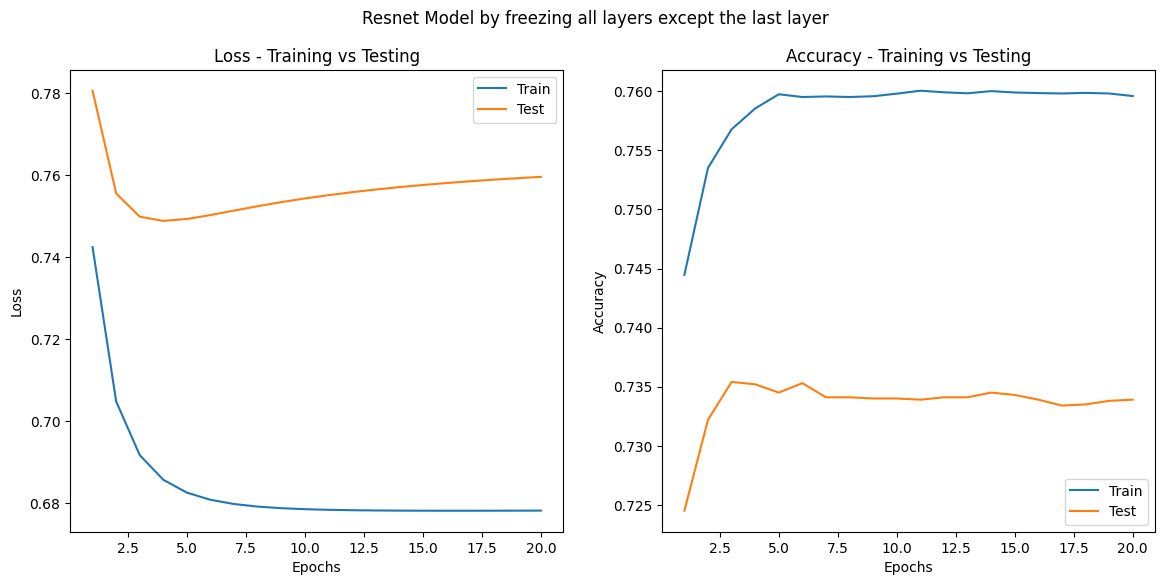

In [ ]:
# Your code below
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Resnet Model by freezing all layers except the last layer',)

ax1.plot(range(1, epochs + 1), train_loss, label="Train")
ax1.plot(range(1, epochs + 1), test_loss, label="Test")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Loss - Training vs Testing")
ax1.legend()

ax2.plot(range(1, epochs + 1), train_accuracy, label="Train")
ax2.plot(range(1, epochs + 1), test_accuracy, label="Test")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy - Training vs Testing")
ax2.legend()

plt.show()

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

### Part A:  From `torchvision.models`, load [`ResNet18`], and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer.


**Train Accuracy** -> 97.2 %

**Test Accuracy** -> 90.6%

**Train Loss** -> 0.077353

**Test Loss** -> 0.451079




**Parameters**


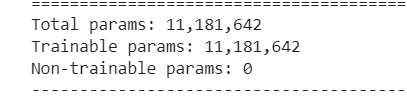


### Part B: Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.



**Train Accuracy** -> 96.7%

**Test Accuracy** -> 90.5%

**Train Loss** -> 0.098547

**Test Loss** -> 0.457233



**Parameters**

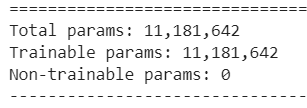

### Part C: Freeze all but the last layer of your adapted ResNet model, and retrain.


**Train Accuracy** -> 76.0%

**Test Accuracy** -> 73.4%

**Train Loss** -> 0.678141

**Test Loss** -> 0.759579



**Parameters**

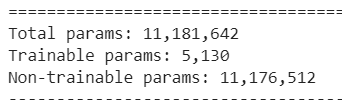

## **Differences Between the Approaches**:

**Initialization**:

Part A began with random weights, implying that it had no prior knowledge of the job and initialized only the fully connected layer.

Part B of the model used weights that had been pre-trained on ImageNet, which had learnt a diverse set of features from a big dataset and again initialized only the fully connected layer.

Part C of the model used weights pre-trained on ImageNet to extract  feature information.




**Training Strategy**:

Parts A and B entailed training all of the model's layers, but Part C just trained the final layer.



**Performance**: Part B, which utilised pretrained weights, had the least train and test accuracy difference, as compared to accuracies of  Part A, which trained from base up with random weights. Whereas, Part C, with most layers frozen, led to reduced accuracy, but the overfitting issue is mostly fixed.
